# ML tool to find residue pair energies to distinguish conformational states  

In [33]:
import mdtraj as md
import glob as g
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [45]:
# Reading trajectory data
path = '/lrlhps/users/l034064/ML_trajs'
files = ['inac','act']

trajs = []
for f in files:
    topol = g.glob(path+'/{}.pdb'.format(f))
    xtc = g.glob(path+'/{}.xtc'.format(f))
    traj = md.load(xtc, top=topol[0])
    trajs.append(traj)
    
#Reading traj for simulation initiallized in Inactive state    
top_inac = trajs[0].topology
atms_inac = top_inac.select('(chainid 1 and (resSeq 125 to 400))') #or (chainid 0 and resname CLR)') # select chain R and cholesterol
traj_inac = trajs[0][::20]
traj_inac = traj_inac.atom_slice(atms_inac)
top_inac = traj_inac.topology
#Reading traj for simulation initiallized in Active state
top_act = trajs[1].topology
atms_act = top_act.select('(chainid 2 and (resSeq 125 to 400))')# or (chainid 3 and resname CLR)') # select chain R and cholesterol
traj_act = trajs[1][::20]
traj_act = traj_act.atom_slice(atms_act)
top_act = traj_act.topology

In [3]:
first_resid = 125

In [4]:
top_inac

<mdtraj.Topology with 1 chains, 279 residues, 4428 atoms, 4482 bonds at 0x2ad620c86a30>

In [5]:
def print_residue_info(traj, name):
    print(f"Residue info for {name}:")
    for chain in traj.topology.chains:
        for residue in chain.residues:
            print(f"Chain: {chain.index}, Residue Name: {residue.name}, Residue Index: {residue.index}, Residue Seq: {residue.resSeq}")
    print("\n")

In [6]:
#Resid 0 is Cholesterol to INAC / Removing cholesterol to test
#Resid 0 is ACE for active 
residue_id = 0
residue = top_act.residue(residue_id)
print(f"Residue ID: {residue_id}, Residue Name: {residue.name}")

Residue ID: 0, Residue Name: GLY


In [7]:
# Define function to check if a residue is aromatic
def is_aromatic(residue):
    aromatic_residues = ['PHE', 'TYR', 'TRP', 'HIS']
    return residue.name in aromatic_residues

In [8]:
def get_aromatic_ring_atoms(residue):
    aromatic_residues = {
        'PHE': ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ'],
        'TYR': ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ'],
        'TRP': ['CG', 'CD1', 'CD2', 'NE1', 'CE2', 'CE3', 'CZ2', 'CZ3', 'CH2'],
        'HIS': ['CG', 'ND1', 'CD2', 'CE1', 'NE2']
    }
    if residue.name in aromatic_residues:
        return [atom.index for atom in residue.atoms if atom.name in aromatic_residues[residue.name]]
    return []

In [22]:
# Define constants for hydrogen bond energy calculation
A = 10  # kcal·Å⁶/mol
B = 5  # kcal/mol

# Define simplified function to calculate hydrogen bond energy
def calculate_hbond_energy(distance, angle):
    return -A / (distance ** 6) - B * np.cos(np.radians(angle)) ** 2


In [39]:
#Define simplified function to calculate pi-pi stacking energy
def calculate_pipi_energy(distance, B=3.0):
    return -B / distance**2

# Function to identify pi-pi interactions based on distance only
def find_pipi_interactions(frame, distance_cutoff=5.0):
    pi_pi_pairs = []
    for i in range(frame.n_residues):
        for j in range(i + 1, frame.n_residues):
            res_i = frame.topology.residue(i)
            res_j = frame.topology.residue(j)
            res_name_i = res_i.name
            res_name_j = res_j.name
            ring_atoms_i = get_aromatic_ring_atoms(res_i)
            ring_atoms_j = get_aromatic_ring_atoms(res_j)
            if ring_atoms_i and ring_atoms_j:
                centroid_i = frame.xyz[0][ring_atoms_i].mean(axis=0)
                centroid_j = frame.xyz[0][ring_atoms_j].mean(axis=0)
                distance = np.linalg.norm(centroid_i - centroid_j) * 10  # Convert nm to Å
                if distance < distance_cutoff:
                    pi_pi_pairs.append((i, j, res_name_i, res_name_j, distance))
    return pi_pi_pairs

In [42]:
# Initialize the dataframe
columns = []

# Iterate over each frame to identify interactions and calculate energies
def get_int(trajectory, topology):
    all_data = []
    for frame_idx, frame in enumerate(trajectory):
        print('Calculating energy for Frame: ', frame_idx)
        frame_data = {}

        # Identify hydrogen bonds
        hbonds = md.baker_hubbard(frame)
        for hbond in hbonds:
            donor = frame.topology.atom(hbond[0])
            acceptor = frame.topology.atom(hbond[2])
            distance = md.compute_distances(frame, [[hbond[0], hbond[2]]])[0][0] * 10  # Convert nm to Å
            # Calculate the angle for the hydrogen bond
            hydrogen = frame.topology.atom(hbond[1])
            donor_position = frame.xyz[0][donor.index]
            acceptor_position = frame.xyz[0][acceptor.index]
            hydrogen_position = frame.xyz[0][hydrogen.index]
            vector_dh = hydrogen_position - donor_position
            vector_ha = acceptor_position - hydrogen_position
            angle = np.degrees(np.arccos(np.dot(vector_dh, vector_ha) / (np.linalg.norm(vector_dh) * np.linalg.norm(vector_ha))))
            energy = calculate_hbond_energy(distance, angle)
            column_name = f"hbond_donor.{donor.residue.name}{donor.residue.index+first_resid}_{acceptor.residue.name}{acceptor.residue.index+first_resid}" #renumber it to get back to original RESNUMBER
            frame_data[column_name] = energy
            if column_name not in columns:
                columns.append(column_name)

        # Identify pi-pi interactions
        pipi_interactions = find_pipi_interactions(frame)
        for res_i, res_j, name_i, name_j, distance in pipi_interactions:
            energy = calculate_pipi_energy(distance)
            column_name = f"pipi_{name_i}{res_i+first_resid}_{name_j}{res_j+first_resid}"
            frame_data[column_name] = energy
           # print(column_name)
            if column_name not in columns:
                columns.append(column_name)

        all_data.append(frame_data)
    return(all_data)

In [43]:
ene_act = get_int(traj_act,top_act)
ene_inac = get_int(traj_inac,top_inac)

Calculating energy for Frame:  0
Calculating energy for Frame:  1
Calculating energy for Frame:  2
Calculating energy for Frame:  3
Calculating energy for Frame:  4
Calculating energy for Frame:  5
Calculating energy for Frame:  6
Calculating energy for Frame:  7
Calculating energy for Frame:  8
Calculating energy for Frame:  9
Calculating energy for Frame:  10
Calculating energy for Frame:  11
Calculating energy for Frame:  12
Calculating energy for Frame:  13
Calculating energy for Frame:  14
Calculating energy for Frame:  15
Calculating energy for Frame:  16
Calculating energy for Frame:  17
Calculating energy for Frame:  18
Calculating energy for Frame:  19
Calculating energy for Frame:  20
Calculating energy for Frame:  21
Calculating energy for Frame:  22
Calculating energy for Frame:  23
Calculating energy for Frame:  24
Calculating energy for Frame:  25
Calculating energy for Frame:  26
Calculating energy for Frame:  27
Calculating energy for Frame:  28
Calculating energy for F

In [46]:
df_act = pd.DataFrame(ene_act, columns=columns)
df_act.index.name = 'Frame'
df_act = df_act.fillna(0)
df_act['label'] = pd.Series('act', index=df_act.index)

df_inac = pd.DataFrame(ene_inac, columns=columns)
df_inac.index.name = 'Frame'
df_inac = df_inac.fillna(0)
df_inac['label'] = pd.Series('inac', index=df_inac.index)

In [27]:
# Drop columns that contain 'hbond_donor' - if you want to use ONLY Pi-Pi
df_act = df_act.drop(columns=[col for col in df_act.columns if 'hbond_donor' in col])
df_inac = df_inac.drop(columns=[col for col in df_inac.columns if 'hbond_donor' in col])

In [36]:
# Load Modules for ML

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import shap

Average Accuracy in distinguishing states: 1.00


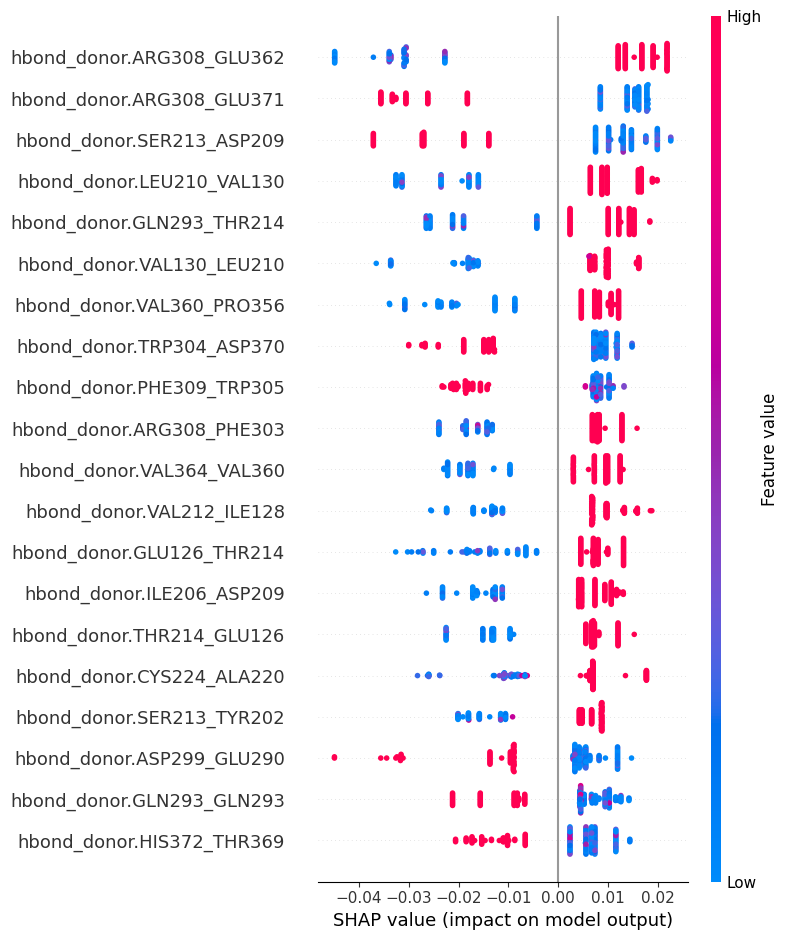

In [37]:
# just example:
df1 = df_inac
df2 = df_act
df3 = df_act 

# Add the num_label column
df1['num_label'] = 0
df2['num_label'] = 1
df3['num_label'] = 2

# Identify all unique columns across all DataFrames
all_columns = set(df1.columns).union(set(df2.columns)).union(set(df3.columns))

# Add missing columns to each DataFrame with zero values
def add_missing_columns(df, all_columns):
    for column in all_columns:
        if column not in df.columns:
            df[column] = 0
    return df

df1 = add_missing_columns(df1, all_columns)
df2 = add_missing_columns(df2, all_columns)
df3 = add_missing_columns(df3, all_columns)

# Ensure columns order is consistent
df1 = df1[sorted(all_columns)]
df2 = df2[sorted(all_columns)]
df3 = df3[sorted(all_columns)]

# Merge the dataframes
merged_df = pd.concat([df1, df2, df3])

# Shuffle the merged dataframe
shuffled_df = merged_df.sample(frac=1).reset_index(drop=True)

y = shuffled_df['num_label']
X = shuffled_df.drop(['label','num_label'], axis=1)


float_columns = X.select_dtypes(include=['float64', 'float32']).columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X[float_columns] = scaler.fit_transform(X[float_columns])


model = RandomForestClassifier(n_estimators=150, random_state=10)
# Set up 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Placeholder to collect SHAP values and accuracies
shap_values_list = []
accuracies = []

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and compute accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    # Compute SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap_values_list.append(shap_values[1])  # shap_values[1] for class 1 (positive class)

# Average accuracy across folds
average_accuracy = np.mean(accuracies)
print(f"Average accuracy in distinguishing states: {average_accuracy:.2f}")

# Aggregate SHAP values across folds
aggregated_shap_values = np.concatenate(shap_values_list)
X_test_aggregated = np.concatenate([X.iloc[test_index] for train_index, test_index in kf.split(X, y)])

# Visualize the SHAP values for the positive class
shap.initjs()
shap.summary_plot(aggregated_shap_values, X_test_aggregated, feature_names=X.columns)